# Classification Practice using MNIST Dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- `DESCR` : key describing the dataset
- `data` : key containing an array with one row per instance and one column per feature
- `target` : key containing an array with labels

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

X, y = mnist["data"].copy(), mnist["target"].copy()
display(X.shape)
display(y.shape)

(70000, 784)

(70000,)

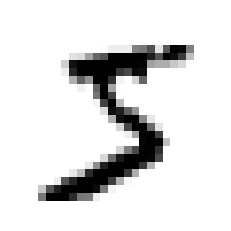

In [29]:
some_digit = X.loc[0]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [30]:
y[0]

'5'

In [31]:
import numpy as np
y = y.astype(np.uint8)